In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [26]:
train_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\validation_data\\train"

In [27]:
val_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\validation_data\\val"

In [28]:
test_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\validation_data\\test"

In [29]:
IMG_WIDTH = 227
IMG_HEIGHT = 227
BATCH_SIZE = 32

# Data Augmentation

In [30]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 1504 images belonging to 4 classes.


In [31]:
valid_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_generator = valid_datagen.flow_from_directory(val_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 186 images belonging to 4 classes.


In [32]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 193 images belonging to 4 classes.


In [33]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classed present in the training and validation datasets\n")
for key,value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classed present in the training and validation datasets

0 : Baby_Cry
1 : Door_Bell
2 : Door_Knock
3 : Fire_Alarm


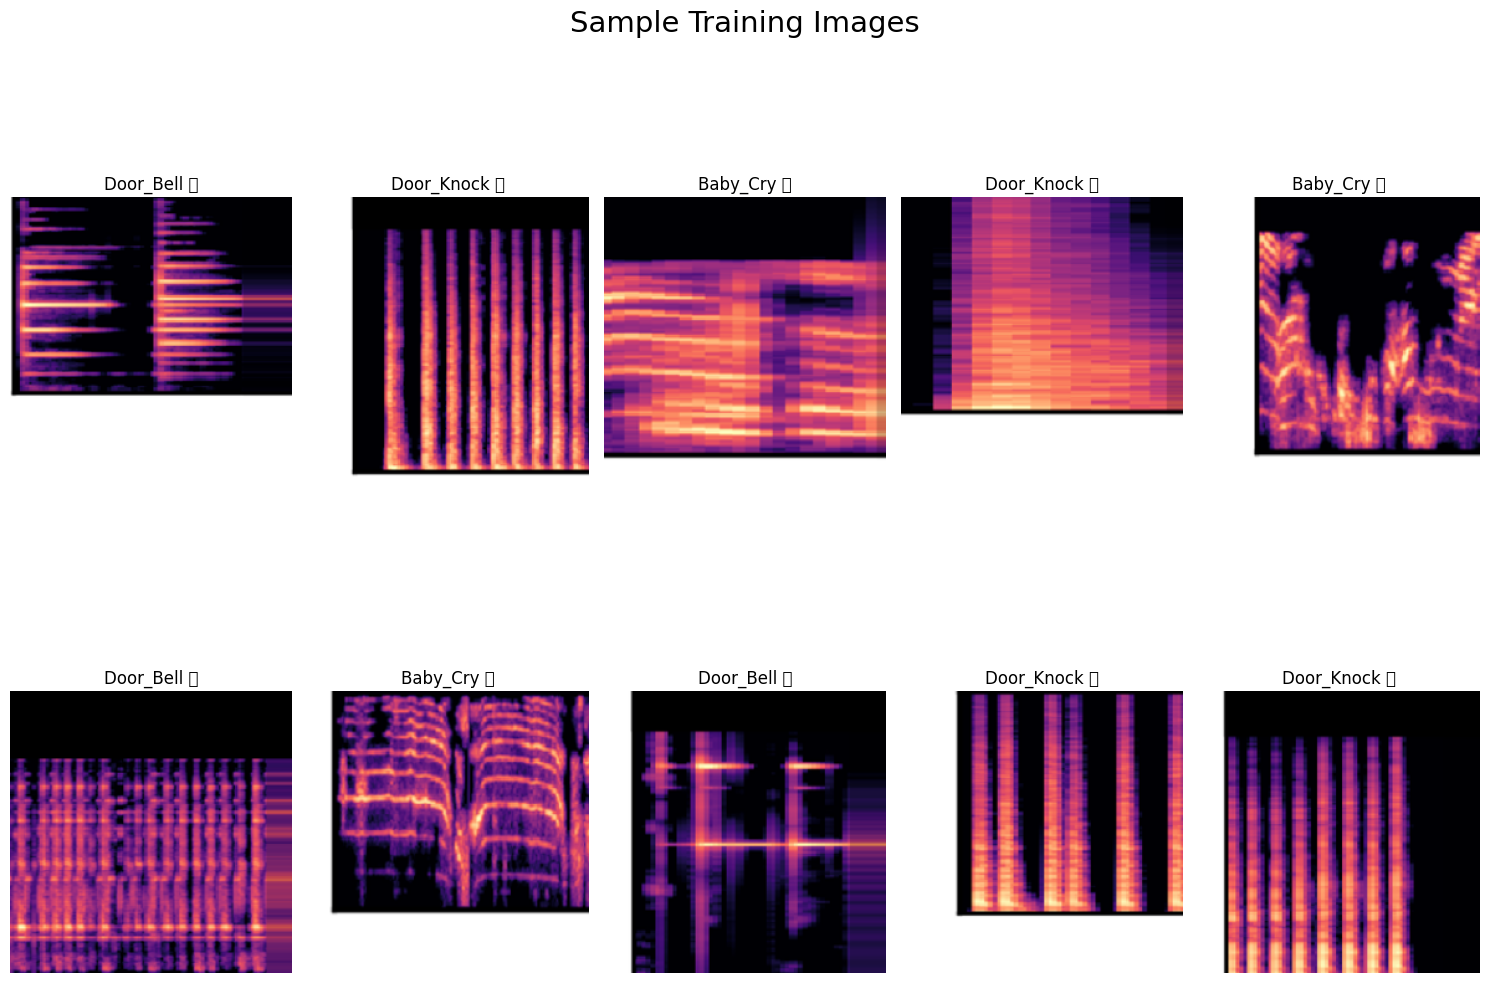

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,12))
idx = 0
for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label} \t")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx +=1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [28]:
# from sklearn.model_selection import train_test_split
# import keras

# dcase_model = Sequential()
# dcase_model.add(Conv2D(16, 7, padding='same',input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))  # X_train.shape[1] = No. of Columns
# dcase_model.add(BatchNormalization())
# dcase_model.add(Activation('relu'))
# dcase_model.add(Conv2D(16,7,padding='same'))
# dcase_model.add(BatchNormalization())
# dcase_model.add(Activation('relu'))
# dcase_model.add(MaxPooling2D(pool_size=(8,8)))
# dcase_model.add(Dropout(0.3))
# dcase_model.add(Conv2D(32,7,padding='same'))
# dcase_model.add(BatchNormalization())
# dcase_model.add(Activation('relu'))
# dcase_model.add(MaxPooling2D(pool_size=(4,4)))
# dcase_model.add(Dropout(0.3))
# dcase_model.add(Flatten())
# dcase_model.add(Dense(100,activation='relu'))
# dcase_model.add(Dropout(0.3))
# dcase_model.add(Dense(4))
# dcase_model.add(Activation('softmax'))
# # opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# #opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
# dcase_model.summary()

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Bidirectional, GRU,Layer
from keras.layers import Flatten, Dense, Reshape
from keras import backend as K

# Custom Attention Layer
class Attention(Layer):
    #constructor method to initialize the layer attributes
    def __init__(self, **kwargs):   #define custome layer attributes
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):  #this method is used to create weights
        print(f'input shape = {input_shape}')
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        #print(f'weights of attention layer: {self.W}')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        #print(f'bias matrix = {self.b}')
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)
    

# Define the model
dcase_model = Sequential()

# Convolutional layers
dcase_model.add(Conv2D(64, (7, 7), strides=(2, 1), padding='same', activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
dcase_model.add(MaxPooling2D((3, 3), strides=(2, 2)))

dcase_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
dcase_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

dcase_model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
dcase_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

dcase_model.add(AveragePooling2D((1, 3), strides=(1, 2)))

dcase_model.add(Flatten())
dcase_model.add(Dense(128, activation='relu'))
dcase_model.add(Reshape((-1, 128)))

# Bi-GRU layer
dcase_model.add(Bidirectional(GRU(units=128, return_sequences=True)))
# attention layer
dcase_model.add(Attention())
# Flatten and dense layers
#dcase_model.add(Flatten())
dcase_model.add(Dense(128, activation='relu'))
dcase_model.add(Dense(4, activation='softmax'))
# Compile the model
dcase_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
dcase_model.summary()


input shape = (None, 1, 256)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 227, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 113, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 113, 64)       36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 113, 64)       36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 57, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 57, 128)       147584    
                           

In [30]:
import keras
opt = keras.optimizers.Adam(lr=0.0001)

In [31]:
from tensorflow.keras import metrics
dcase_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])#,metrics.Precision(),metrics.Recall()])
dcase_model_history=dcase_model.fit(train_generator,
                                    batch_size=16,
                                    epochs=100,
                                    validation_data=valid_generator)
                                      #)

Epoch 1/100
47/47 [==============================] - 30s 446ms/step - loss: 1.2253 - accuracy: 0.4368 - val_loss: 0.9860 - val_accuracy: 0.6183
Epoch 2/100
47/47 [==============================] - 12s 247ms/step - loss: 0.7988 - accuracy: 0.7021 - val_loss: 0.6754 - val_accuracy: 0.7312
Epoch 3/100
47/47 [==============================] - 12s 243ms/step - loss: 0.6173 - accuracy: 0.7699 - val_loss: 0.4725 - val_accuracy: 0.8118
Epoch 4/100
47/47 [==============================] - 11s 238ms/step - loss: 0.5473 - accuracy: 0.7899 - val_loss: 0.4837 - val_accuracy: 0.8441
Epoch 5/100
47/47 [==============================] - 11s 238ms/step - loss: 0.4967 - accuracy: 0.7979 - val_loss: 0.4456 - val_accuracy: 0.8118
Epoch 6/100
47/47 [==============================] - 11s 237ms/step - loss: 0.5086 - accuracy: 0.7965 - val_loss: 0.4447 - val_accuracy: 0.8602
Epoch 7/100
47/47 [==============================] - 11s 237ms/step - loss: 0.4321 - accuracy: 0.8351 - val_loss: 0.4068 - val_accuracy:

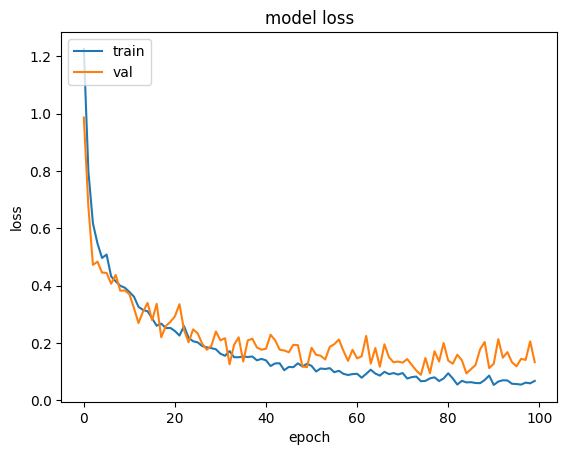

In [32]:
plt.plot(dcase_model_history.history['loss'])
plt.plot(dcase_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

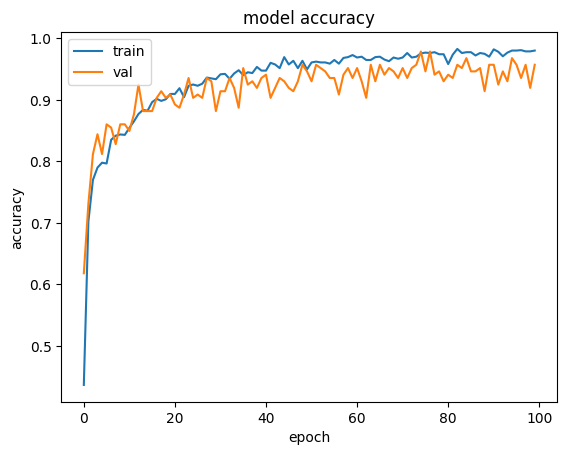

In [33]:
plt.plot(dcase_model_history.history['accuracy'])
plt.plot(dcase_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
#printing accuracy
train_accuracy = dcase_model_history.history['accuracy']
val_accuracy = dcase_model_history.history['val_accuracy']
print(max(val_accuracy))

0.9784946441650391


# saving the model

In [1]:
model_path = "C:\\Users\\PC\\Desktop\\lisnen_research_files\\audio_research_crnn_files\\models\\crnn_attention.keras"  #path to your saved model


In [2]:
dcase_model.save(model_path)

NameError: name 'dcase_model' is not defined

In [5]:
# load model
dcase_model = load_model(model_path)

ValueError: Exception encountered when calling layer "attention" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 1, 256), dtype=float32).

Call arguments received by layer "attention" (type Attention):
  • inputs=tf.Tensor(shape=(None, 1, 256), dtype=float32)
  • mask=None
  • training=None
  • return_attention_scores=False
  • use_causal_mask=False

In [37]:
test_predictions = dcase_model.predict(test_generator)

7/7 [==============================] - 3s 277ms/step


# visualizing the interpretation of model

In [38]:
import librosa
import numpy as np
def melspectrogram(audio_file):
    y,sr = librosa.load(audio_file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,sr=sr,n_mels=128,fmax=8000)
    s_db = librosa.power_to_db(mel_spectrogram,ref=np.max)
    return s_db

In [39]:
#converting spectrogram to model format(32,227,227,3)
def preprocess(spectrogram):
    spectrogram = np.stack([spectrogram]*3,axis=-1)  #creating 3 channels
    spectrogram = np.resize(spectrogram,new_shape=(227,227,3))  #creating inthe input format
    spectrogram = np.expand_dims(spectrogram,axis=0) #adding batch_size to the dimension
    return spectrogram


In [40]:
audio_file ="C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\youtube_audioset\\Baby_Cry\\1THljuwMb94_11.wav"  #add any random sample
mel_spectrogram = melspectrogram(audio_file)
spectrogram = preprocess(mel_spectrogram)
predictions = dcase_model.predict(spectrogram)
print(f'predictions={predictions}')

1/1 [==============================] - 1s 817ms/step
predictions=[[0.00905124 0.01999009 0.00188403 0.96907467]]


In [41]:
class_names = ['Baby cry', 'Door bell', 'door knock', 'fire alarm']
for i, class_name in enumerate(class_names):
        print(f"Prediction for {class_name}: {predictions[0][i]}")

Prediction for Baby cry: 0.009051235392689705
Prediction for Door bell: 0.019990092143416405
Prediction for door knock: 0.0018840336706489325
Prediction for fire alarm: 0.9690746665000916


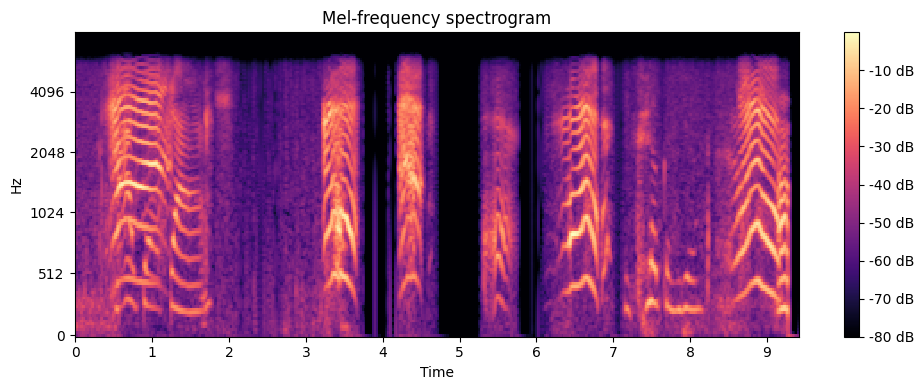

In [42]:
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Generate the mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

# Example usage
y, sr = librosa.load(audio_file, sr=22050)
plot_spectrogram(y, sr)


In [44]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [45]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(spectrogram[0].astype('double'), dcase_model.predict, top_labels=5, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 10/1000 [00:00<00:21, 45.35it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▏         | 20/1000 [00:00<00:22, 43.24it/s]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 30/1000 [00:00<00:21, 45.16it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 40/1000 [00:00<00:20, 46.41it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 50/1000 [00:01<00:20, 47.06it/s]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 60/1000 [00:01<00:20, 45.00it/s]

1/1 [==============================] - 0s 141ms/step


  7%|▋         | 70/1000 [00:01<00:22, 42.09it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 80/1000 [00:01<00:20, 43.94it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▉         | 90/1000 [00:02<00:20, 45.03it/s]

1/1 [==============================] - 0s 120ms/step


 10%|█         | 100/1000 [00:02<00:19, 45.77it/s]

1/1 [==============================] - 0s 125ms/step


 11%|█         | 110/1000 [00:02<00:19, 46.32it/s]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 120/1000 [00:02<00:18, 46.74it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 130/1000 [00:02<00:19, 43.58it/s]

1/1 [==============================] - 0s 134ms/step


 14%|█▍        | 140/1000 [00:03<00:19, 44.41it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 150/1000 [00:03<00:19, 44.74it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 160/1000 [00:03<00:18, 46.18it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 170/1000 [00:03<00:17, 46.34it/s]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 180/1000 [00:03<00:17, 46.56it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 190/1000 [00:04<00:17, 46.58it/s]

1/1 [==============================] - 0s 125ms/step


 20%|██        | 200/1000 [00:04<00:17, 46.97it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 210/1000 [00:04<00:16, 47.15it/s]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 220/1000 [00:04<00:16, 47.28it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 230/1000 [00:05<00:16, 46.61it/s]

1/1 [==============================] - 0s 131ms/step


 24%|██▍       | 240/1000 [00:05<00:17, 43.33it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 250/1000 [00:05<00:17, 43.40it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 260/1000 [00:05<00:16, 44.13it/s]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 270/1000 [00:05<00:16, 45.49it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 280/1000 [00:06<00:15, 46.23it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 290/1000 [00:06<00:15, 46.63it/s]

1/1 [==============================] - 0s 115ms/step


 30%|███       | 300/1000 [00:06<00:14, 46.84it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 310/1000 [00:06<00:14, 47.16it/s]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 320/1000 [00:07<00:14, 47.19it/s]

1/1 [==============================] - 0s 133ms/step


 33%|███▎      | 330/1000 [00:07<00:14, 46.75it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 340/1000 [00:07<00:14, 46.37it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▌      | 350/1000 [00:07<00:13, 46.73it/s]

1/1 [==============================] - 0s 120ms/step


 36%|███▌      | 360/1000 [00:07<00:13, 47.64it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 370/1000 [00:08<00:14, 43.89it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 380/1000 [00:08<00:13, 44.96it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 390/1000 [00:08<00:13, 45.71it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████      | 400/1000 [00:08<00:12, 46.27it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████      | 410/1000 [00:08<00:12, 46.47it/s]

1/1 [==============================] - 0s 128ms/step


 42%|████▏     | 420/1000 [00:09<00:12, 46.35it/s]

1/1 [==============================] - 0s 135ms/step


 43%|████▎     | 430/1000 [00:09<00:12, 46.07it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 440/1000 [00:09<00:12, 46.34it/s]

1/1 [==============================] - 0s 129ms/step


 45%|████▌     | 450/1000 [00:09<00:11, 46.43it/s]

1/1 [==============================] - 0s 132ms/step


 46%|████▌     | 460/1000 [00:10<00:11, 46.40it/s]

1/1 [==============================] - 0s 134ms/step


 47%|████▋     | 470/1000 [00:10<00:11, 45.07it/s]

1/1 [==============================] - 0s 130ms/step


 48%|████▊     | 480/1000 [00:10<00:11, 45.17it/s]

1/1 [==============================] - 0s 125ms/step


 49%|████▉     | 490/1000 [00:10<00:11, 45.27it/s]

1/1 [==============================] - 0s 126ms/step


 50%|█████     | 500/1000 [00:10<00:11, 42.15it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████     | 510/1000 [00:11<00:11, 43.34it/s]

1/1 [==============================] - 0s 137ms/step


 52%|█████▏    | 520/1000 [00:11<00:10, 44.00it/s]

1/1 [==============================] - 0s 135ms/step


 53%|█████▎    | 530/1000 [00:11<00:10, 43.11it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 540/1000 [00:11<00:10, 44.20it/s]

1/1 [==============================] - 0s 130ms/step


 55%|█████▌    | 550/1000 [00:12<00:10, 44.90it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 560/1000 [00:12<00:09, 45.70it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 570/1000 [00:12<00:09, 46.91it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 580/1000 [00:12<00:09, 46.46it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████▉    | 590/1000 [00:12<00:08, 46.81it/s]

1/1 [==============================] - 0s 128ms/step


 60%|██████    | 600/1000 [00:13<00:08, 47.06it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 610/1000 [00:13<00:08, 47.23it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 620/1000 [00:13<00:08, 46.68it/s]

1/1 [==============================] - 0s 128ms/step


 63%|██████▎   | 630/1000 [00:13<00:08, 43.67it/s]

1/1 [==============================] - 0s 134ms/step


 64%|██████▍   | 640/1000 [00:14<00:08, 44.37it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 650/1000 [00:14<00:07, 45.18it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 660/1000 [00:14<00:07, 45.39it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 670/1000 [00:14<00:07, 45.66it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 680/1000 [00:14<00:06, 45.92it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 690/1000 [00:15<00:06, 45.84it/s]

1/1 [==============================] - 0s 140ms/step


 70%|███████   | 700/1000 [00:15<00:06, 45.71it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████   | 710/1000 [00:15<00:06, 45.63it/s]

1/1 [==============================] - 0s 135ms/step


 72%|███████▏  | 720/1000 [00:15<00:06, 44.97it/s]

1/1 [==============================] - 0s 131ms/step


 73%|███████▎  | 730/1000 [00:16<00:05, 45.69it/s]

1/1 [==============================] - 0s 137ms/step


 74%|███████▍  | 740/1000 [00:16<00:05, 45.67it/s]

1/1 [==============================] - 0s 136ms/step


 75%|███████▌  | 750/1000 [00:16<00:05, 45.60it/s]

1/1 [==============================] - 0s 122ms/step


 76%|███████▌  | 760/1000 [00:16<00:05, 43.09it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 770/1000 [00:16<00:05, 44.16it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 780/1000 [00:17<00:04, 44.72it/s]

1/1 [==============================] - 0s 136ms/step


 79%|███████▉  | 790/1000 [00:17<00:04, 45.02it/s]

1/1 [==============================] - 0s 138ms/step


 80%|████████  | 800/1000 [00:17<00:04, 45.19it/s]

1/1 [==============================] - 0s 130ms/step


 81%|████████  | 810/1000 [00:17<00:04, 45.26it/s]

1/1 [==============================] - 0s 136ms/step


 82%|████████▏ | 820/1000 [00:18<00:04, 44.72it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████▎ | 830/1000 [00:18<00:03, 43.77it/s]

1/1 [==============================] - 0s 128ms/step


 84%|████████▍ | 840/1000 [00:18<00:03, 43.66it/s]

1/1 [==============================] - 0s 130ms/step


 85%|████████▌ | 850/1000 [00:18<00:03, 44.20it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▌ | 860/1000 [00:18<00:03, 44.52it/s]

1/1 [==============================] - 0s 138ms/step


 87%|████████▋ | 870/1000 [00:19<00:02, 44.77it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████▊ | 880/1000 [00:19<00:02, 45.04it/s]

1/1 [==============================] - 0s 135ms/step


 89%|████████▉ | 890/1000 [00:19<00:02, 42.68it/s]

1/1 [==============================] - 0s 130ms/step


 90%|█████████ | 900/1000 [00:19<00:02, 43.65it/s]

1/1 [==============================] - 0s 129ms/step


 91%|█████████ | 910/1000 [00:20<00:02, 43.55it/s]

1/1 [==============================] - 0s 132ms/step


 92%|█████████▏| 920/1000 [00:20<00:01, 44.14it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 930/1000 [00:20<00:01, 44.99it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 940/1000 [00:20<00:01, 45.28it/s]

1/1 [==============================] - 0s 129ms/step


 95%|█████████▌| 950/1000 [00:20<00:01, 45.32it/s]

1/1 [==============================] - 0s 134ms/step


 96%|█████████▌| 960/1000 [00:21<00:00, 45.36it/s]

1/1 [==============================] - 0s 130ms/step


 97%|█████████▋| 970/1000 [00:21<00:00, 46.03it/s]

1/1 [==============================] - 0s 130ms/step


 98%|█████████▊| 980/1000 [00:21<00:00, 45.84it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 990/1000 [00:21<00:00, 45.74it/s]

1/1 [==============================] - 0s 125ms/step


100%|██████████| 1000/1000 [00:22<00:00, 45.33it/s]


In [46]:
explanation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-39.5..1.0].


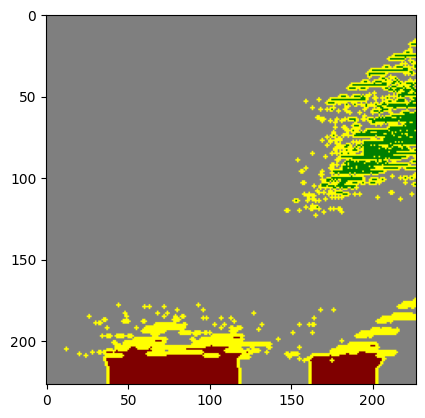

In [48]:

from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

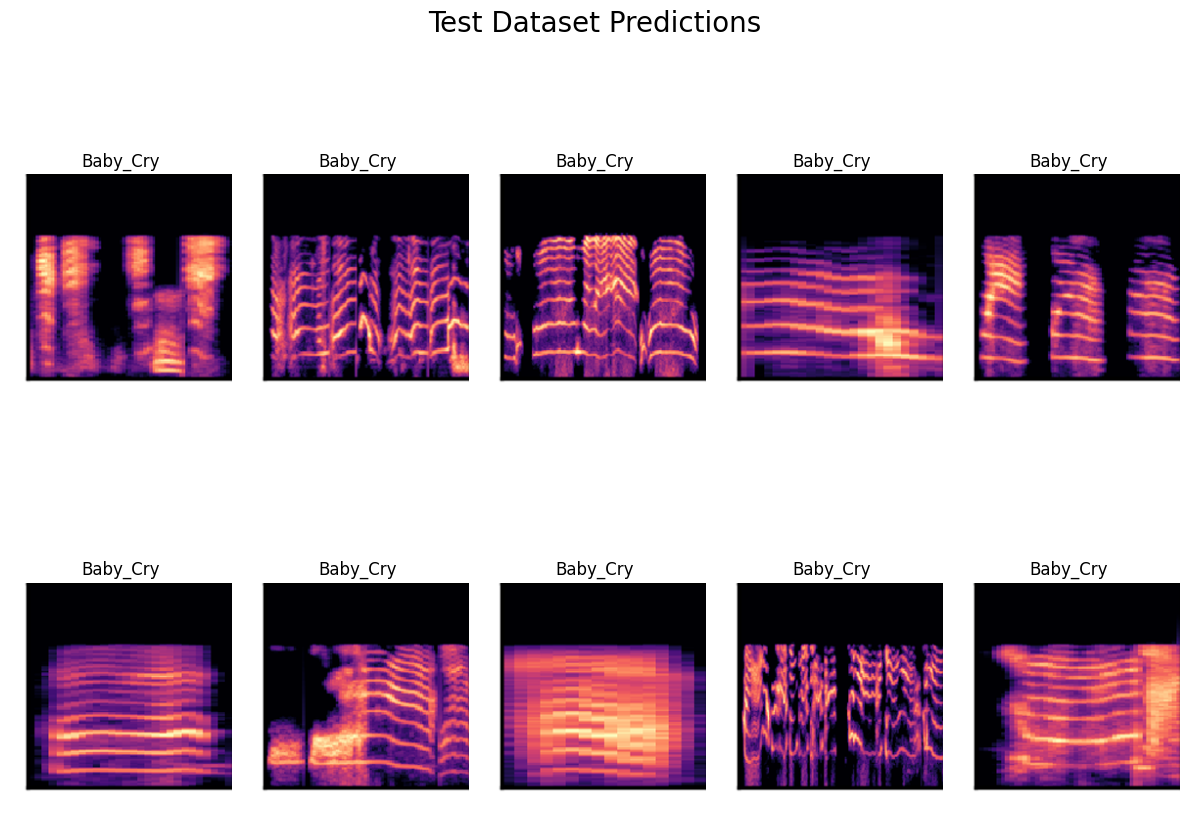

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(test_predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [79]:
test_loss, test_accuracy = dcase_model.evaluate(test_generator, batch_size=BATCH_SIZE)

7/7 [==============================] - 1s 40ms/step - loss: 0.1190 - accuracy: 0.9430


In [80]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.11898070573806763
Test Accuracy: 0.9430052042007446


# Confusion Matrix

In [81]:
y_pred = np.argmax(test_predictions, axis=1)
y_true = test_generator.classes

In [52]:
conf_mx = confusion_matrix(y_true,y_pred)
conf_mx

array([[48,  3,  0, 11],
       [ 3, 24,  0,  3],
       [ 0,  1, 48,  0],
       [ 4, 10,  0, 38]], dtype=int64)

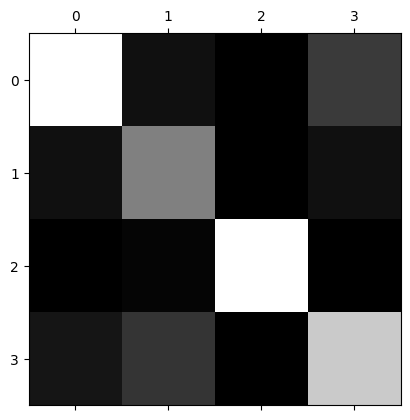

In [53]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

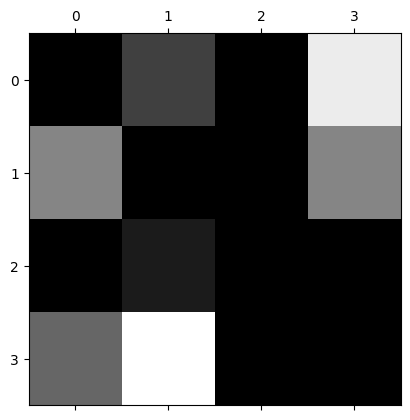

In [56]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

In [ ]:
# cf_mtx = confusion_matrix(y_true, y_pred)

# group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
# box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
# box_labels = np.asarray(box_labels).reshape(6, 6)

# plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
#            cmap="YlGnBu", fmt="", annot=box_labels)
# plt.xlabel('Predicted Classes')
# plt.ylabel('True Classes')
# plt.show()

In [82]:
print(classification_report(y_true, y_pred, target_names=labels.values()))


              precision    recall  f1-score   support

    Baby_Cry       0.93      1.00      0.96        62
   Door_Bell       0.93      0.83      0.88        30
  Door_Knock       1.00      1.00      1.00        49
  Fire_Alarm       0.92      0.88      0.90        52

    accuracy                           0.94       193
   macro avg       0.94      0.93      0.94       193
weighted avg       0.94      0.94      0.94       193



# Wrong Predictions

In [83]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [84]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

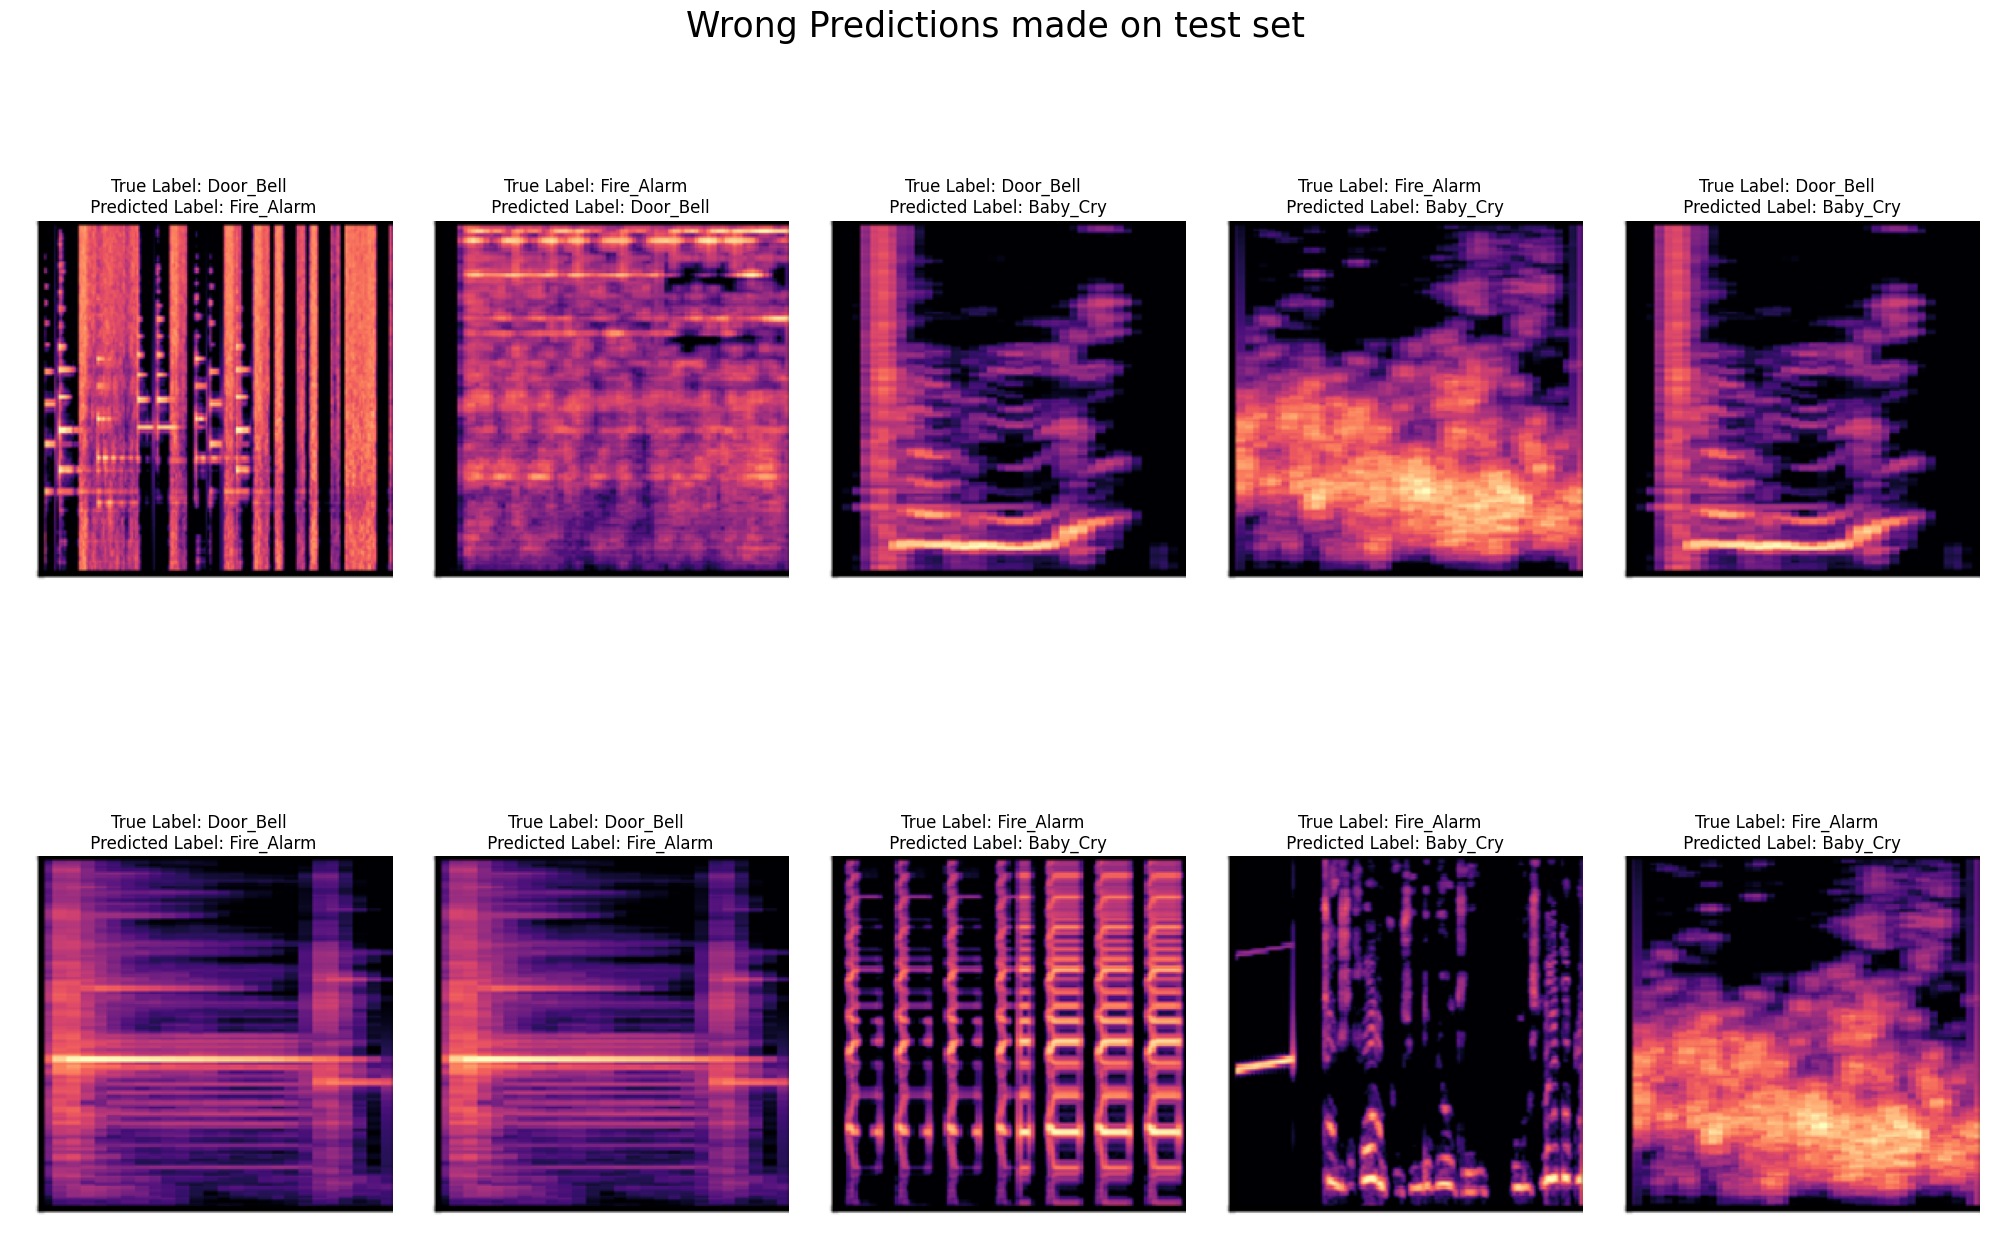

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=25)
plt.show()

# Change file Names using Python

In [ ]:
#Baby Cry Test files renaming
# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Baby_Cry_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'btest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1

# Door Knock Test files renaming

# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Door_Knock_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'dktest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1

# Door bell Test files renaming
# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Door_Bell_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'dbtest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1

# Fire Alarm Test files remaining
# import os

# count = 1
# folder_path = "/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/test/Fire_Alarm_Melspectrograms"

# for file in os.listdir(folder_path):
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(os.path.join(folder_path, file)):
#         # Create the new file name with the count prefix
#         new_name = f'fatest-{count}.png'
#         # Join the folder path with the file name to get full paths
#         old_path = os.path.join(folder_path, file)
#         new_path = os.path.join(folder_path, new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         # Increment count for the next file
#         count += 1


# Split images into train test validation

In [ ]:
# import splitfolders
# splitfolders.ratio(train_dataset_path, output="/Users/pranayrajsarap/Spoken Language Processing/December_2021/lisnen_segmented_working_data/validation_data", seed=1337, ratio=(.8, 0.1,0.1))